# Tutorial 01 - Loading Exported Data and Visualizing Pupillometry
In this tutorial we will look at how to load data that was exported from Pupil Player into Python in order to visualize pupillometry related data. Please check the documentation of [Pupil Player](https://docs.pupil-labs.com/#pupil-player) to see how to export data. This Notebook comes together with a sample recording whose raw data was already exported using Pupil Player.

## 1 - Loading Exported Data
Let's start off by inspecting the overall file structure we have in our sample recording!

In [6]:
import os

recording_location = '/cluster/users/Marc/code/pupil-software/pupil-tutorials/sample_recording'

def print_file_structure(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in sorted(files):
            print('{}{}'.format(subindent, f))
print_file_structure(recording_location)

sample_recording/
    eye0.mp4
    eye0_timestamps.npy
    eye1.mp4
    eye1_timestamps.npy
    gaze.pldata
    gaze_timestamps.npy
    info.csv
    notify.pldata
    notify_timestamps.npy
    pupil.pldata
    pupil_timestamps.npy
    user_info.csv
    world.intrinsics
    world.mp4
    world_timestamps.npy
    offline_data/
    exports/
        000/
            export_info.csv
            gaze_positions.csv
            pupil_gaze_positions_info.txt
            pupil_positions.csv
            world_viz.mp4


The original recording data - coming out of Pupil Capture, Pupil Service or Pupil Mobile - is located at the top-level of the recording folder. Exports from Pupil Player will be saved in a subfolder called `exports`. Every time we trigger an export in Pupil Player, a new folder will be created in `exports` containing the respective data. You might want to use multiple exports e.g. to export multiple sub-sections of your entire recording. In our sample data, there is only one export inside the folder `000`.

### Available Files
Files like the ones in our sample export will be contained in every export.

- `export_info.csv` - Meta information on the export containing e.g. the export date or the dta format version.
- `pupil_positions.csv` - A list of all pupil datums. See below for more infotmation.
- `gaze_positions.csv` - A list of all gaze datums. See below for more infotmation.
- `pupil_gaze_positions_info.txt` - Contains documentation on the contents of `pupil_positions.csv` and `gaze_positions.csv`
- `world_viz.mp4` - The exported section of world camera video.

Some Pupil Player plugins might add additional files. Check out the [data format](https://docs.pupil-labs.com/#data-format) documentation for more details on these files.


In this tutorial we are interested in visualizing pupillometry data, which is contained in `pupil_positions.csv`. We use Pandas to load the CSV-file into a Python dictionary.

In [11]:
import pandas as pd
exported_pupil_csv = os.path.join(recording_location, 'exports', '000', 'pupil_positions.csv')
pupil_pd_frame = pd.read_csv(exported_pupil_csv)

In [12]:
print("Columns present in pupil data:")
print(pupil_pd_frame.columns)

Columns present in pupil data:
Index(['timestamp', 'index', 'id', 'confidence', 'norm_pos_x', 'norm_pos_y',
       'diameter', 'method', 'ellipse_center_x', 'ellipse_center_y',
       'ellipse_axis_a', 'ellipse_axis_b', 'ellipse_angle', 'diameter_3d',
       'model_confidence', 'model_id', 'sphere_center_x', 'sphere_center_y',
       'sphere_center_z', 'sphere_radius', 'circle_3d_center_x',
       'circle_3d_center_y', 'circle_3d_center_z', 'circle_3d_normal_x',
       'circle_3d_normal_y', 'circle_3d_normal_z', 'circle_3d_radius', 'theta',
       'phi', 'projected_sphere_center_x', 'projected_sphere_center_y',
       'projected_sphere_axis_a', 'projected_sphere_axis_b',
       'projected_sphere_angle'],
      dtype='object')


### Individual Datums
As we can see every datum contains many values. In this sample recording we used the 3D gaze mapping mode and most of the values are concerned with the state of the 3D eye model. We will now take a closer look at the subset of values most important in our use case regarding pupillometry: 

- `timestamp` - The timestamp at which the sample was recorded.
- `id` - Identifies the eye to which the sample belongs to. By default samples with `id = 0` belong to the right eye, while samples with `id = 1` belong to the left eye. 
- `confidence` - Confidence in the pupil detection.
- `index` - The world frame this sample matches too. By default the eye cameras record more frames per second than the world camera. Therefore, there is not a one-to-one mapping between the images of each eye camera and the world camera. Instead multiple eye images are mapped to the same world frame via this index.
- `norm_pos` - The position of the pupil in the eye image
- `diameter` - The pupil diameter

For more information on the other available values please refer to the [data format](https://docs.pupil-labs.com/#data-format) documentation.

Let's take a look at a few values from our sample data!

In [14]:
eye0_df = pupil_pd_frame[pupil_pd_frame.id == 0]
eye1_df = pupil_pd_frame[pupil_pd_frame.id == 1]
pd.options.display.float_format = '{:.3f}'.format

print("eye0 data:")
print(eye0_df[['timestamp', 'id', 'confidence', 'index', 'norm_pos_x', 'norm_pos_y', 'diameter']][:10])
print("eye1 data:")
print(eye1_df[['timestamp', 'id', 'confidence', 'index', 'norm_pos_x', 'norm_pos_y', 'diameter']][:10])

eye0 data:
    timestamp  id  confidence  index  norm_pos_x  norm_pos_y  diameter
1   79630.834   0       1.000      1       0.261       0.650    25.907
3   79630.842   0       1.000      1       0.261       0.650    26.140
5   79630.850   0       1.000      1       0.260       0.651    26.237
7   79630.858   0       1.000      2       0.261       0.651    26.576
9   79630.866   0       1.000      2       0.261       0.651    25.879
11  79630.875   0       1.000      2       0.261       0.650    25.888
13  79630.883   0       1.000      2       0.261       0.650    25.926
15  79630.891   0       1.000      3       0.261       0.649    26.118
17  79630.899   0       1.000      3       0.261       0.650    25.999
19  79630.907   0       1.000      3       0.261       0.649    25.821
eye1 data:
    timestamp  id  confidence  index  norm_pos_x  norm_pos_y  diameter
0   79630.827   1       1.000      1       0.449       0.536    32.670
2   79630.835   1       1.000      1       0.449       

## 2 - Visualize Pupillometry Data

Now that we have the data available in Python we can immedeately visualize it using the Matplotlib library.

### Plot Pupil Diameter
The pupil diameter as a function of time:

Text(0.5,1,'Pupil Diameter')

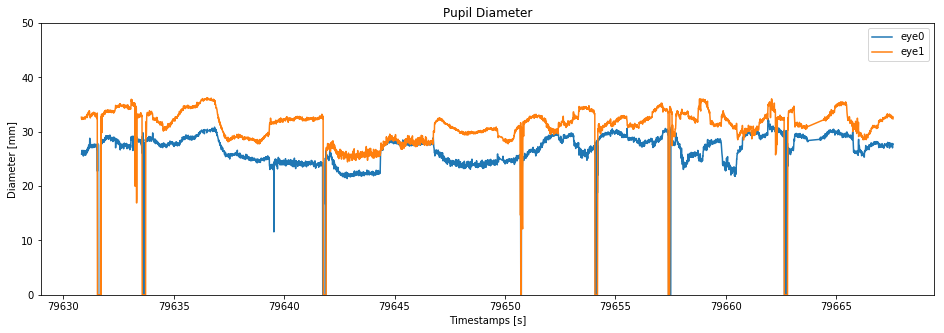

In [15]:
plt.figure(figsize=(16, 5))
plt.plot(eye0_df['timestamp'], eye0_df['diameter'])
plt.plot(eye1_df['timestamp'], eye1_df['diameter'])
plt.legend(['eye0', 'eye1'])
plt.xlabel('Timestamps [s]')
plt.ylabel('Diameter [mm]')
plt.ylim((0, 50))
plt.title('Pupil Diameter')

As we can see there are unreasonable spikes in the data. These spikes are due to false positive pupil detections typically occuring during blinks. We can easily filter out these erroneous values using the `confidence` measure. 

Text(0.5,1,'Pupil Diameter (only high confidence values)')

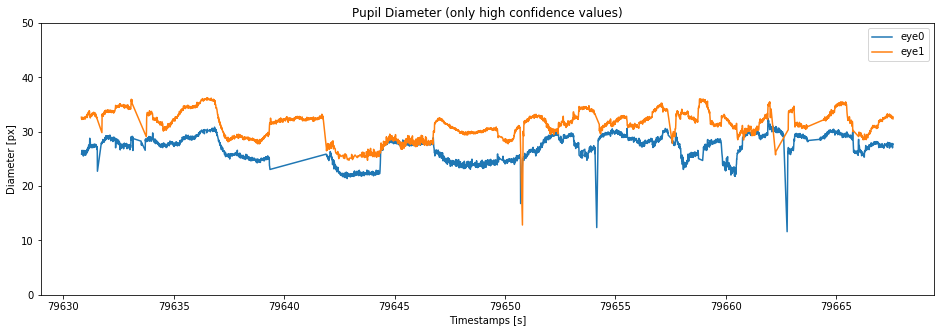

In [18]:
eye0_high_conf = eye0_df['confidence'] > 0.95
eye1_high_conf = eye1_df['confidence'] > 0.95

plt.figure(figsize=(16, 5))
plt.plot(eye0_df['timestamp'][eye0_high_conf], eye0_df['diameter'][eye0_high_conf])
plt.plot(eye1_df['timestamp'][eye1_high_conf], eye1_df['diameter'][eye1_high_conf])
plt.legend(['eye0', 'eye1'])
plt.xlabel('Timestamps [s]')
plt.ylabel('Diameter [px]')
plt.ylim((0, 50))
plt.title('Pupil Diameter (only high confidence values)')

### Plot Pupil Positions
Next, we will visualize the spatial distribution of pupil positions in the eye image in form of a scatter plot. Again we discard low confidence points. We will color code each point with it's timestamp, this way we can roughly see the trajactory each pupil had during the recording.

Text(0.5,1,'eye1')

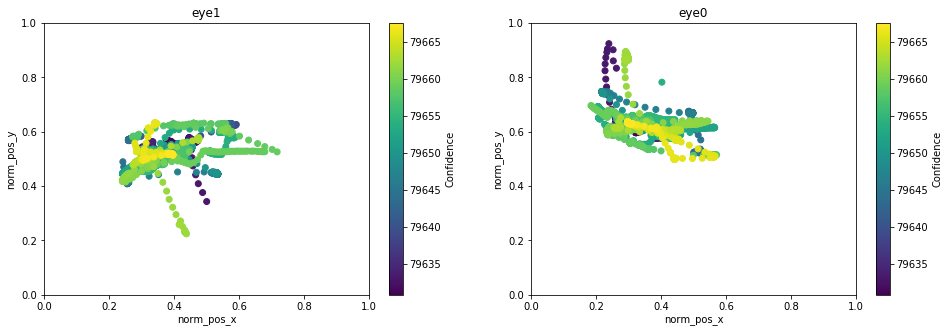

In [27]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 2)
plt.scatter(eye0_df['norm_pos_x'][eye0_high_conf], eye0_df['norm_pos_y'][eye0_high_conf], c=eye0_df['timestamp'][eye0_high_conf])
plt.colorbar().ax.set_ylabel('Confidence')
plt.xlabel('norm_pos_x')
plt.ylabel('norm_pos_y')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('eye0')


plt.subplot(1, 2, 1)
plt.scatter(eye1_df['norm_pos_x'][eye1_high_conf], eye1_df['norm_pos_y'][eye1_high_conf], c=eye1_df['timestamp'][eye1_high_conf])
plt.colorbar().ax.set_ylabel('Confidence')
plt.xlabel('norm_pos_x')
plt.ylabel('norm_pos_y')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('eye1')